In [7]:
#importing necessary packages
import pandas as pd
import numpy as np
import string
string.punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import defaultdict


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sjtightmbpmarch2020/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sjtightmbpmarch2020/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
#importing datasets
true_data = pd.read_csv("True.csv")
fake_data = pd.read_csv("Fake.csv")

#assigning lables for classification
true_data['label'] = 1
fake_data['label'] = 0

#combining datasets into one dataset
news_data = pd.concat([true_data, fake_data], ignore_index= True)

#creating a content column by combining the title and text columns
news_data['content'] = news_data['title'] + " " + news_data['text']

#creating a stopword list using NLTK's stopwords and including punctuation
stopword_list = stopwords.words('english')
punctuation = [p for p in string.punctuation]
stopword_list.extend(punctuation)


In [9]:
#importing the nrc emotional lexicon
nrc = pd.read_csv("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt",
    sep='\t',  
    header=None,  
    names=['word', 'emotion', 'value']  
)

nrc_lexicon = defaultdict(lambda: defaultdict(int))
for _, row in nrc.iterrows():
    nrc_lexicon[row["word"]][row["emotion"]] = row["value"]


print(list(nrc_lexicon.items())[0:20])

[('aback', defaultdict(<class 'int'>, {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0})), ('abacus', defaultdict(<class 'int'>, {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 1})), ('abandon', defaultdict(<class 'int'>, {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 1, 'surprise': 0, 'trust': 0})), ('abandoned', defaultdict(<class 'int'>, {'anger': 1, 'anticipation': 0, 'disgust': 0, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 1, 'surprise': 0, 'trust': 0})), ('abandonment', defaultdict(<class 'int'>, {'anger': 1, 'anticipation': 0, 'disgust': 0, 'fear': 1, 'joy': 0, 'negative': 1, 'positive': 0, 'sadness': 1, 'surprise': 1, 'trust': 0})), ('abate', defaultdict(<class 'int'>, {'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'j

In [10]:
#creating a corpus by tokenizing the words and making them lowercase
corpus_lower = []
for doc in news_data['content']:
    tokens = [token.lower() for token in doc.split() if token.lower() not in stopword_list]
    corpus_lower.append(tokens)


In [11]:
#iterating through the documnets and counting the occurence of words associated with each of the words that appear in the nrc emotion lexicon
document_emotions = []

for tokens in corpus_lower:
    emotion_count = defaultdict(int)

    for word in tokens: 
        for emotion, value in nrc_lexicon[word].items():
            emotion_count[emotion] += value

    document_emotions.append(emotion_count)

#creating a data frame with counts of how many times each emotion appears in each document. Filling missing values with zeros to represent that that specific emotion does not appear in that specific document
emotion_df = pd.DataFrame(document_emotions).fillna(0)
#assiging labels to the documents that correspond to true and fake news articles 
labels = [1]*len(true_data) + [0]*len(fake_data)  # 1 = true, 0 = fake
emotion_df['label'] = labels
print(emotion_df)

       anger  anticipation  disgust   fear   joy  negative  positive  sadness  \
0        4.0           8.0      0.0    9.0   7.0      20.0      36.0     12.0   
1       14.0          33.0      3.0   25.0   5.0      14.0      32.0      3.0   
2        6.0          10.0      1.0    5.0   2.0      11.0      15.0      3.0   
3        5.0           6.0      4.0    4.0   5.0      11.0      18.0      3.0   
4        4.0          17.0      1.0   12.0   3.0      23.0      28.0      7.0   
...      ...           ...      ...    ...   ...       ...       ...      ...   
44893    4.0           7.0      8.0    8.0   6.0      22.0      23.0      7.0   
44894    3.0           7.0      0.0    5.0   4.0       6.0      11.0      3.0   
44895   88.0          80.0     49.0  121.0  56.0     148.0     169.0     56.0   
44896    9.0          13.0     10.0   12.0   8.0      19.0      15.0     10.0   
44897   20.0          13.0      3.0   25.0   6.0      33.0      29.0      7.0   

       surprise  trust  lab

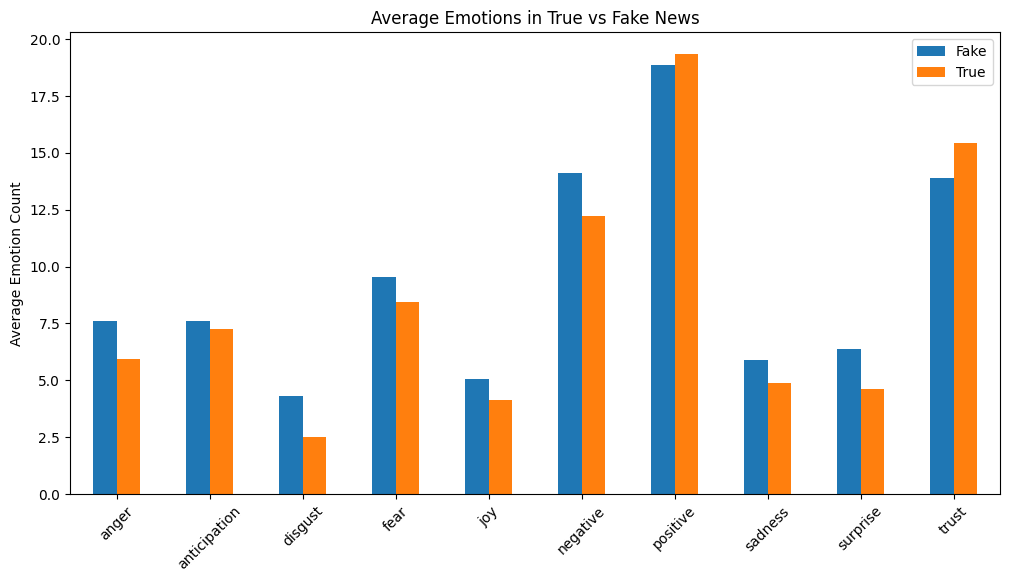

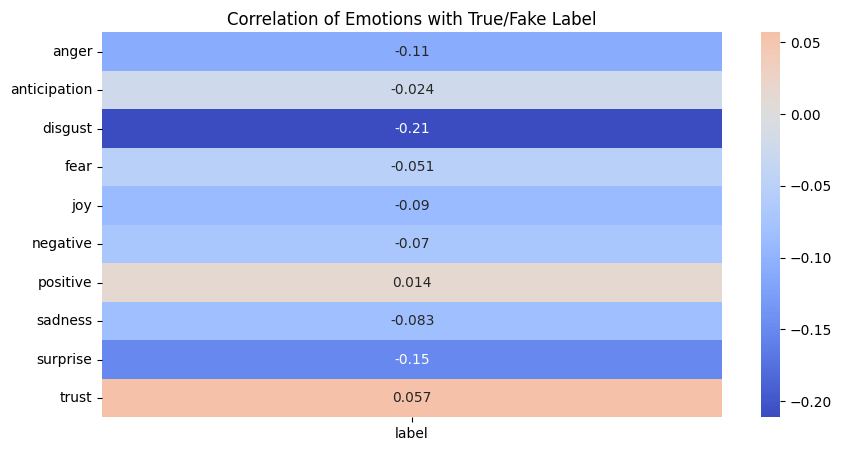

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

#list of emotion columns
emotion_columns = [col for col in emotion_df.columns if col not in ['label', 'predicted_label']]

#average emotion per label
avg_emotions = emotion_df.groupby('label')[emotion_columns].mean().T
avg_emotions.columns = ['Fake', 'True']

#bar plot of average emotions per label
avg_emotions.plot(kind='bar', figsize=(12,6))
plt.ylabel("Average Emotion Count")
plt.title("Average Emotions in True vs Fake News")
plt.xticks(rotation=45)
plt.show()


#correlation heatmap with label and emotions
corr = emotion_df[emotion_columns + ['label']].corr()['label'].drop('label')

plt.figure(figsize=(10,5))
sns.heatmap(corr.to_frame(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of Emotions with True/Fake Label")
plt.show()

In [13]:

#creating weights based on correlation between true and fake news
true_weights = {'trust': 0.57, 'positive': 0.14}
fake_weights = {'anger': 1.1, 'anticipation': 0.24, 'disgust': 2.1,'fear': 0.51, 'joy':0.9, 'negative': 0.7, 'sadness': 0.83, 'surprise': 1.5}

#scaling down weight of fake news related emotions to reduce impact of fake news being much more emotional and prevent over-classification of articles as fake news
scale_factor = 0.25 
fake_weights_scaled = {e: w * scale_factor for e, w in fake_weights.items()}

#calculating "true score" and "fake score" by multiplying the weights by the count of the number of times a specific emotion appears in an article
emotion_df['true_score'] = sum(emotion_df[e] * w for e, w in true_weights.items())
emotion_df['fake_score'] = sum(emotion_df[e] * w for e, w in fake_weights_scaled.items())

#calculating an overall score by subtracting the "fake score" from the "true score"
emotion_df['score'] = emotion_df['true_score'] - emotion_df['fake_score']

#normalizing the score by dividng the score by the number of emotional words in the article so that articles with more emotion don't have relatively larger or smaller scores
emotion_df['normalized_score'] = emotion_df['score'] / emotion_df[emotion_columns].sum(axis=1)
emotion_df = emotion_df.dropna(subset=['normalized_score'])

#setting the classification threshold
threshold = 0  

#predict true if normalized score is > 0 and false otherwise
emotion_df['predicted_label'] = (emotion_df['normalized_score'] > threshold).astype(int)


#check accuracy
accuracy = (emotion_df['predicted_label'] == emotion_df['label']).mean()
print(f"Accuracy: {accuracy:.2f}")


#create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#true and predicted labels
y_true = emotion_df['label']
y_pred = emotion_df['predicted_label']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)

Accuracy: 0.65
[[15732  7578]
 [ 8095 13319]]


AUC: 0.70


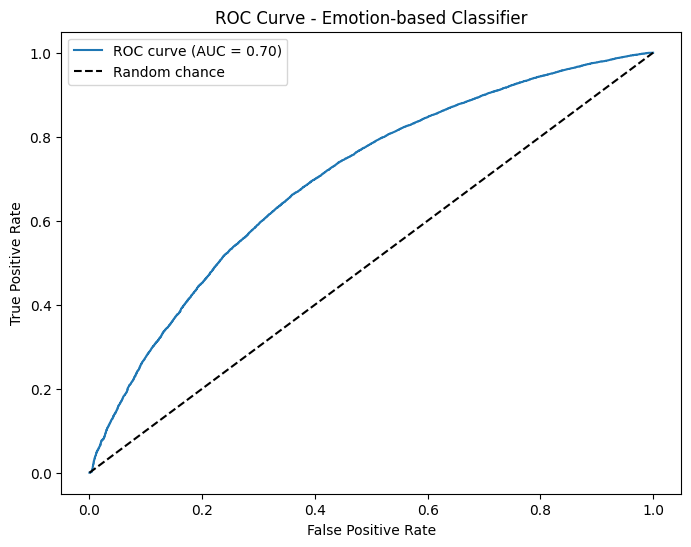

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#true labels
y_true = emotion_df['label']


y_score = emotion_df['normalized_score']


fpr, tpr, thresholds = roc_curve(y_true, y_score)

#compute AUC
auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.2f}")

#plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Emotion-based Classifier')
plt.legend()
plt.show()
